In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [49]:
def parascatter(df,xs,ys,xerrs=None,yerrs=None,size=3,
                s=None,lw=None,color=None,scale='linear',wspace=0.3,hspace=0.4):
    plt.figure(figsize=(len(ys)*size,len(xs)*size))
    for i in range(len(xs)):
        for j in range(len(ys)):
            plt.subplot(len(xs),len(ys),j+i*len(ys)+1)
            plt.scatter(df[xs[i]],df[ys[j]],
                        s=s,color=color,lw=lw)
            if xerrs:
                plt.plot([df[xs[i]]-df[xerrs[i]],df[xs[i]]+df[xerrs[i]]],
                         [df[ys[j]],df[ys[j]]],
                         color=color,lw=lw)
            if yerrs:
                plt.plot([df[xs[i]],df[xs[i]]],
                         [df[ys[j]]-df[yerrs[j]],df[ys[j]]+df[yerrs[j]]],
                         color=color,lw=lw)
            plt.xscale(scale)
            plt.yscale(scale)
            plt.xlabel(xs[i])
            plt.ylabel(ys[j])
    plt.subplots_adjust(wspace=wspace,hspace=hspace)

In [50]:
df0 = pd.read_excel('lucas-data.xlsx')

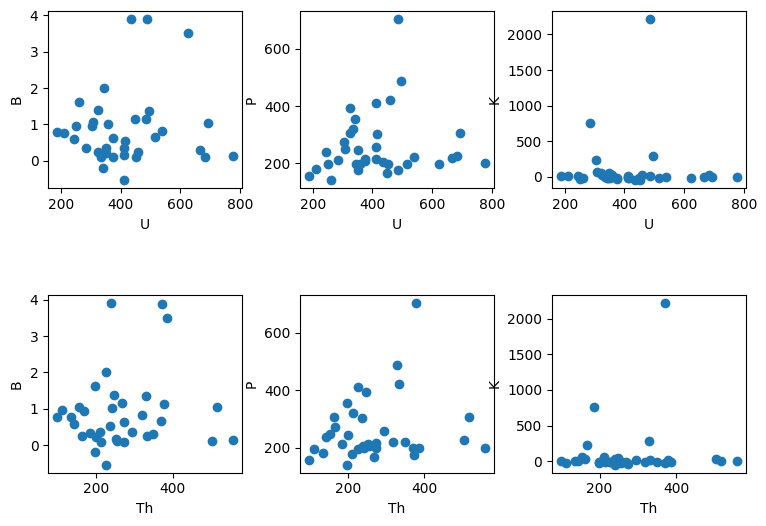

In [51]:
parascatter(df0,['U','Th'],['B','P','K'])
plt.subplots_adjust(hspace=0.6)

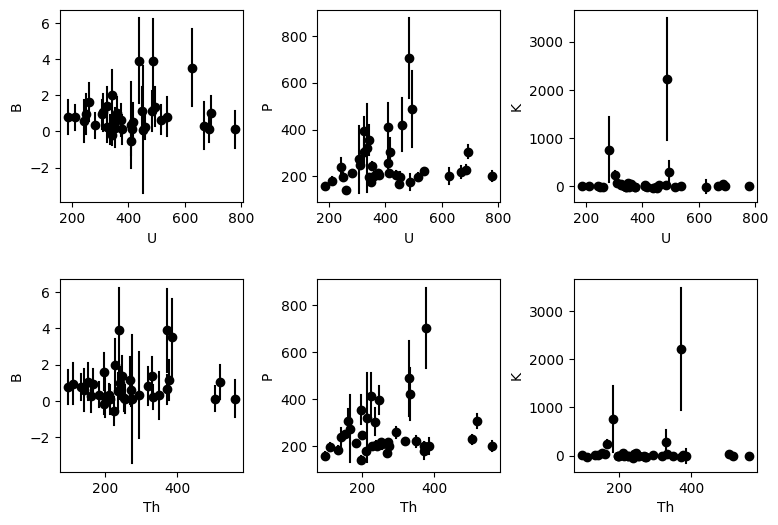

In [53]:
parascatter(df0,['U','Th'],['B','P','K'],
            None,['B err','P err','K err'],
            color='k',wspace=0.4)

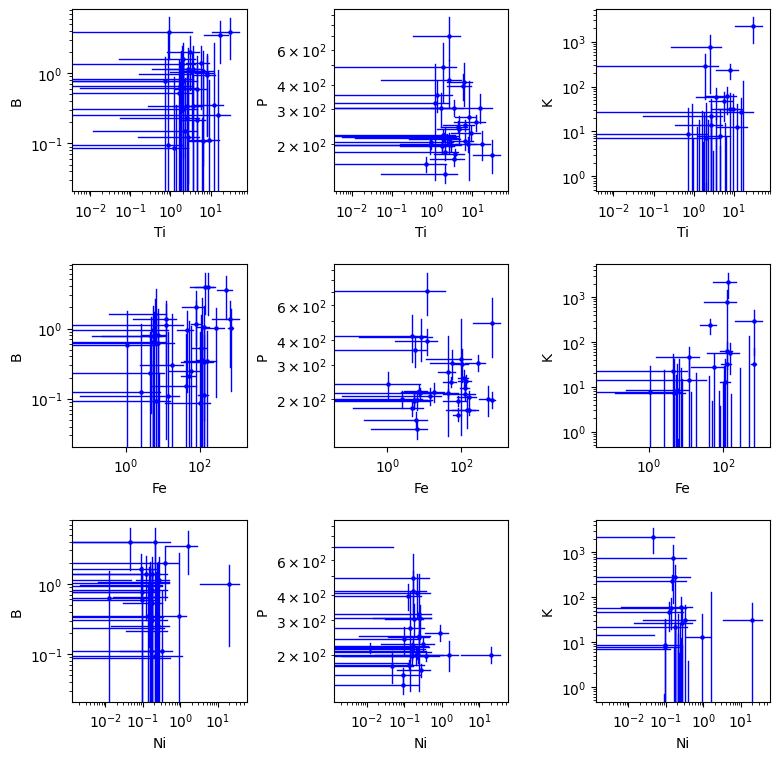

In [54]:
parascatter(df0,['Ti','Fe','Ni'],['B','P','K'],
            ['Ti err','Fe err','Ni err'],['B err','P err','K err'],
            s=5,lw=1,color='b',scale='log',wspace=0.5)

In [55]:
df1  = pd.read_excel('eric-data.xlsx')
mats = np.unique(df1['Ref Mat ID'])

(0.0, 20.0)

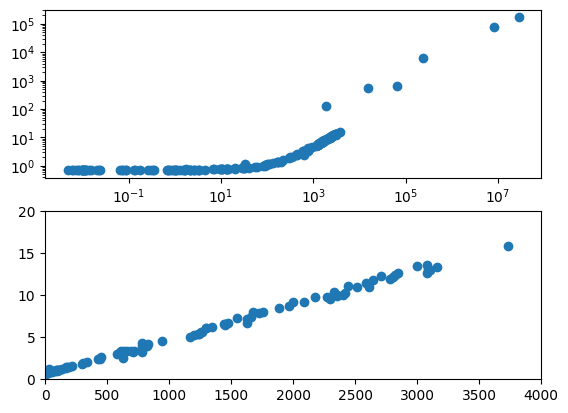

In [72]:
i = 1
x = df1[df1['Ref Mat ID']==mats[i]]['87Rb/86Sr']
y = df1[df1['Ref Mat ID']==mats[i]]['87Sr/86Sr']
plt.subplot(211)
plt.scatter(x,y)
plt.xscale('log')
plt.yscale('log')
plt.subplot(212)
plt.scatter(x,y)
plt.xlim(0,4e+3)
plt.ylim(0,20)

In [75]:
lam   = 1.393e-11 # from https://doi.org/10.1016/j.epsl.2010.11.004 nebel et al epsl 2011
xlb,xhb,ylb,yhb = 0,4000,0,20
conds = (x>xlb)&(x<xhb)&(y>ylb)&(y<yhb)
polyf = np.polyfit(x[conds],y[conds],1)
age   = np.log(polyf[0]+1)/lam*1e-6 #Ma
print(age)

290.915496244742


Text(0.5, 1.0, 'CAN1 granite')

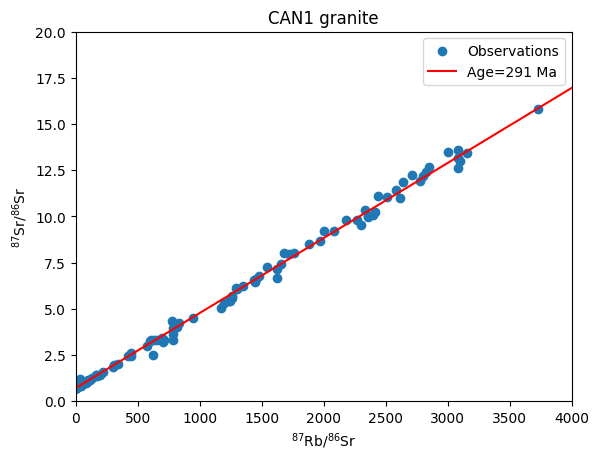

In [77]:
plt.scatter(x[conds],y[conds],label='Observations')
plt.plot([xlb,xhb],np.polyval(polyf,[xlb,xhb]),'r',label='Age=%d Ma'%np.round(age))
plt.xlim(xlb,xhb)
plt.ylim(ylb,yhb)
plt.xlabel('$^{87}$Rb/$^{86}$Sr')
plt.ylabel('$^{87}$Sr/$^{86}$Sr')
plt.legend()
plt.title('%s'%mats[i])